<a href="https://colab.research.google.com/github/jkeconr/datawork/blob/main/data_NABO_KH_230302.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# 코드로 형식 지정됨
```

## Dataset for NABO_KH
##### last updated: Jan 13, 2023

In [ ]:
# import libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pylab as plt
import datetime as dt
import os
import warnings
import requests # python 3.6

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

import pandas_datareader as pdr
import pandas_datareader.data as web
from pandas_datareader import wb
from pandas_datareader.data import DataReader

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# set the working directory

os.chdir('/content/gdrive/MyDrive/Colab Notebooks/datawork')

# 1. Data 
## 1.1. OECD Economic Outlook data 
- Forecast error(Boehm(2020), government consumption(CGV) and investment(IGV)) 


### A. Sources: downloaded data from papers 
> ##### a. Boehm(2020, JME) 
> * sample period: quarterly, 1981:1 -2016:4 
> * components of government spending 
>  - gov. consumption : CGV 
>  - gov. investment : IGV

> ##### b. Auerbach and Gorodnichenko(2013, AEAPP) 
> * sample period: semi-annual, 2004:H1-2011:H2 
>   * **should be modified to match quarterly data**
> * components of government spending 
>  - gov. consumption : CGV 
> * Used in Huidrom et al.(2020, JME)  


### B. Format(Boehm(2020)) 
##### 1. Forecast error   
* FE_x : t-1/t-2 forecast of $\frac{x_t - x_{t-1}}{GDP_{t-1}}$, 
* x= CGV(gon consumption) or IGV(gov investment) 

##### 2. Forecast revision 
* rev_h_x = $ \frac{x_{t+h} - x_{t-1}}{GDP_{t-1}}$, $h=0,...,20$ 
* x= CGV(gon consumption) or IGV(gov investment) 




In [ ]:
# import EO data 
data =  pd.read_excel('data_EO_1.xlsx').sort_values(by=['isocode', 'quarter']).reset_index(drop=True)

data

,country,isocode,quarter,region,income,oecd,g7,tradeopen,finopen_ci,finopen_ci_n,...,rev_18_IGV,rev_19_IGV,rev_20_IGV,year,year_half,time,rev_H0,rev_H1,FE_0,FE_1
0,Argentina,ARG,1950-01-01,7,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Argentina,ARG,1950-04-01,7,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Argentina,ARG,1950-07-01,7,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Argentina,ARG,1950-10-01,7,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,ARG,1951-01-01,7,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14495,South Africa,ZAF,2021-04-01,5,2,NaN,NaN,55.2194,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14496,South Africa,ZAF,2021-07-01,5,2,NaN,NaN,57.4124,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14497,South Africa,ZAF,2021-10-01,5,2,NaN,NaN,59.4472,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14498,South Africa,ZAF,2022-01-01,5,2,NaN,NaN,61.1930,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# number of countries & sample period

print('number of countries:', data['isocode'].unique().shape[0])
print(data['isocode'].unique())
print('start:', np.min(data['quarter'].unique()))
print('end:', np.max(data['quarter'].unique()))

data.info()

number of countries: 50
['ARG' 'AUS' 'AUT' 'BEL' 'BGR' 'BRA' 'CAN' 'CHE' 'CHL' 'COL' 'CYP' 'CZE'
 'DEU' 'DNK' 'ESP' 'EST' 'FIN' 'FRA' 'GBR' 'GRC' 'HKG' 'HRV' 'HUN' 'IDN'
 'IND' 'IRL' 'ISR' 'ITA' 'JPN' 'KOR' 'LTU' 'LUX' 'LVA' 'MEX' 'MLT' 'NLD'
 'NOR' 'NZL' 'POL' 'PRT' 'ROU' 'RUS' 'SGP' 'SVK' 'SVN' 'SWE' 'THA' 'TUR'
 'USA' 'ZAF']
start: 1950-01-01T00:00:00.000000000
end: 2022-04-01T00:00:00.000000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14500 entries, 0 to 14499
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   country        14500 non-null  object        
 1   isocode        14500 non-null  object        
 2   quarter        14500 non-null  datetime64[ns]
 3   region         14500 non-null  int64         
 4   income         14500 non-null  int64         
 5   oecd           10440 non-null  float64       
 6   g7             2030 non-null   float64       
 7   tradeopen      6191 non-n

In [ ]:
# descriptive statistics

pd.options.display.float_format = '{:.4f}'.format
round(data[['ggdebt', 'ggcon', 'gdp', 'reer', 'ca', 'pcon', 'cds', 'FE_1_CGV', 'FE_1_IGV', 'rev_4_CGV', 'rev_4_IGV', 'rev_20_CGV', 'rev_20_IGV' ]].describe(), 2)

,ggdebt,ggcon,gdp,reer,ca,pcon,cds,FE_1_CGV,FE_1_IGV,rev_4_CGV,rev_4_IGV,rev_20_CGV,rev_20_IGV
count,5587.0000,6442.0000,6389.0000,7591.0000,6086.0000,6131.0000,3616.0000,871.0000,815.0000,2225.0000,2167.0000,1953.0000,1895.0000
mean,55.9600,4532532484647.4199,38866750643511.4688,97.4300,-0.0800,23000562720867.8594,210.8800,6.0200,0.0200,0.3800,0.0700,1.7300,0.4000
std,34.4500,21624065103603.4688,234588086412315.8438,19.1000,5.5100,133911320765830.5781,760.8600,10.9600,0.0900,0.5000,0.4400,1.5700,0.9900
min,3.6800,29940.8600,1309589293.3700,32.4200,-47.7600,815770839.9200,1.7700,-101.6500,-0.9500,-1.9200,-2.6700,-3.5900,-3.2800
25%,31.7900,10819697477.8500,55490076984.7400,89.7800,-3.1300,29285201853.6500,30.9800,1.3400,-0.0000,0.1000,-0.1300,0.8500,-0.0900
50%,48.3300,53732045822.3500,267664960565.1500,97.9400,-0.7200,153703649530.0100,73.2600,6.0600,0.0200,0.3700,0.0600,1.6200,0.3300
75%,71.9400,194813015692.2100,768761357303.6100,103.8500,2.4400,476742224468.7500,177.4400,11.0800,0.0400,0.6700,0.2600,2.6200,0.8100
max,227.1800,251067293692856.6875,2896892682330298.0000,281.9200,32.6100,1559219424873803.0000,26089.2000,183.2700,0.7000,2.4600,3.3400,8.8800,4.3900


In [ ]:
# 

data = data.rename(columns={'country':'country', 'isocode':'isocode', 'quarter':'quarter', 'FE_1_CGV':'FE', 'rev_4_CGV':'FR'})




country Australia
isocode AUS
end: 2016-10-01T00:00:00.000000000
obs.: 52
des. stat. count   52.0000
mean     8.5813
std      5.4844
min     -2.2887
25%      4.2357
50%      9.0955
75%     13.8944
max     15.7381
Name: FE, dtype: float64

country Belgium
isocode BEL
end: 2016-10-01T00:00:00.000000000
obs.: 50
des. stat. count   50.0000
mean     7.1231
std      4.7190
min     -4.0240
25%      4.8980
50%      8.5706
75%      9.9151
max     15.0978
Name: FE, dtype: float64

country Canada
isocode CAN
end: 2016-10-01T00:00:00.000000000
obs.: 52
des. stat. count   52.0000
mean     8.3992
std      6.8847
min     -2.5376
25%      2.1541
50%      9.4214
75%     15.2743
max     20.7989
Name: FE, dtype: float64

country Germany
isocode DEU
end: 2016-10-01T00:00:00.000000000
obs.: 52
des. stat. count   52.0000
mean     5.7388
std      4.2870
min     -2.4248
25%      3.6974
50%      6.2504
75%      8.3361
max     14.3854
Name: FE, dtype: float64

country Denmark
isocode DNK
end: 2015-07-01T00:00:0

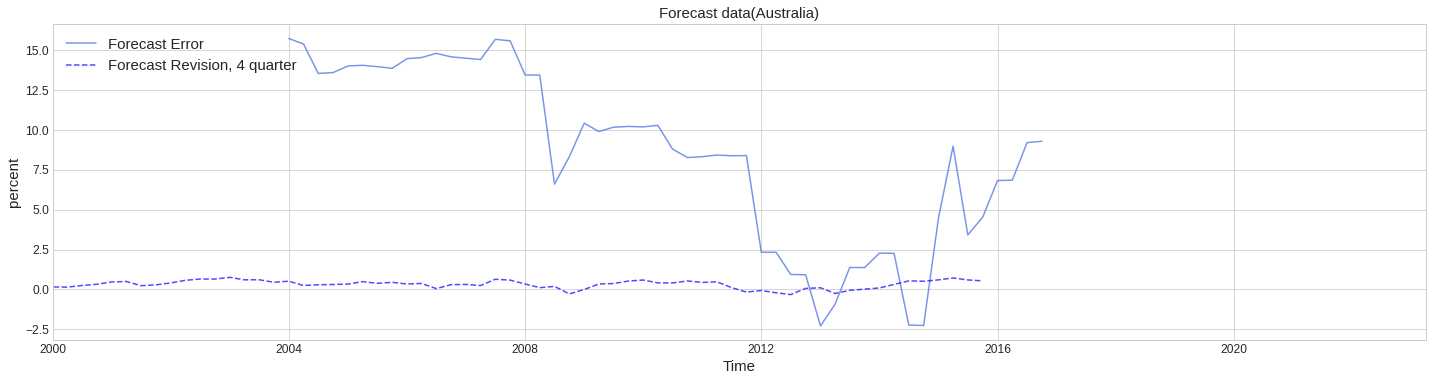

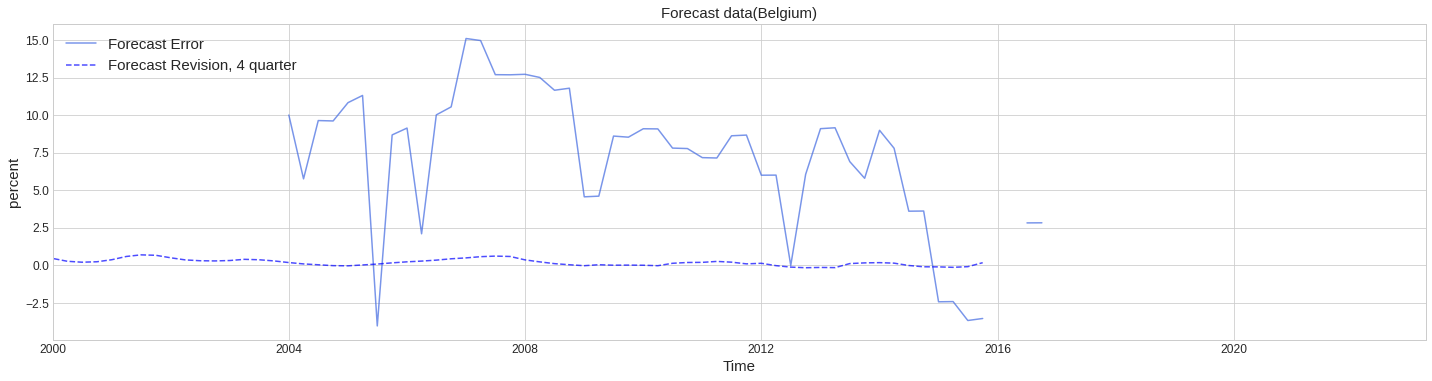

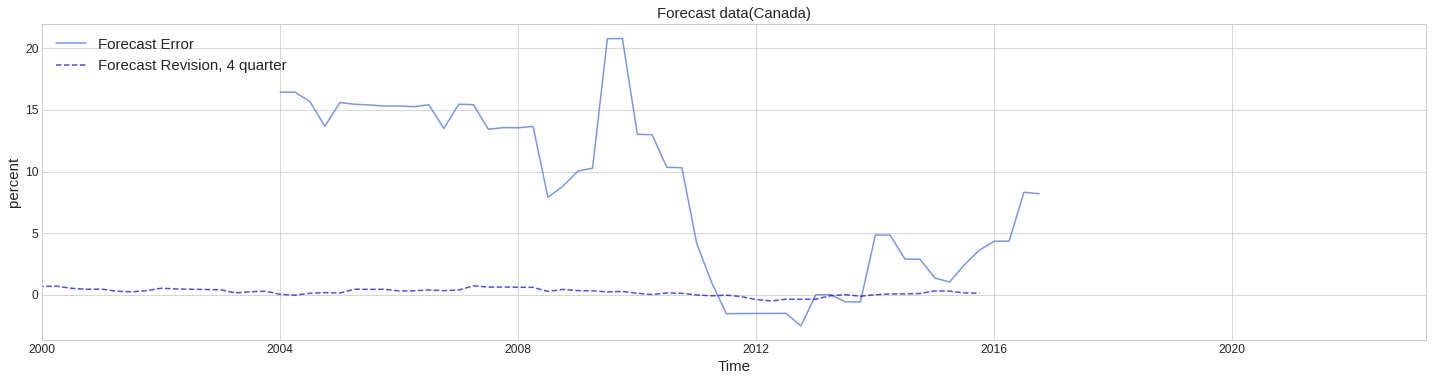

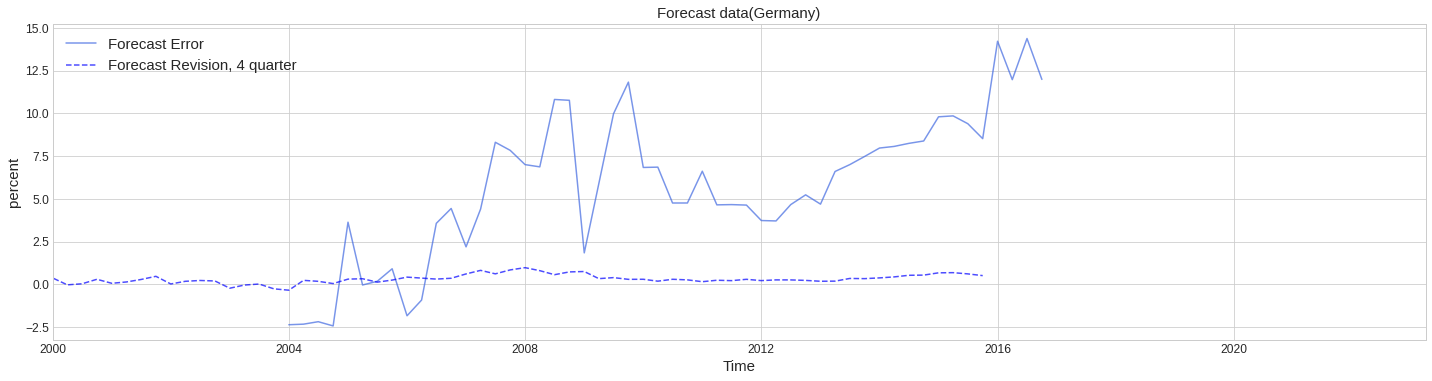

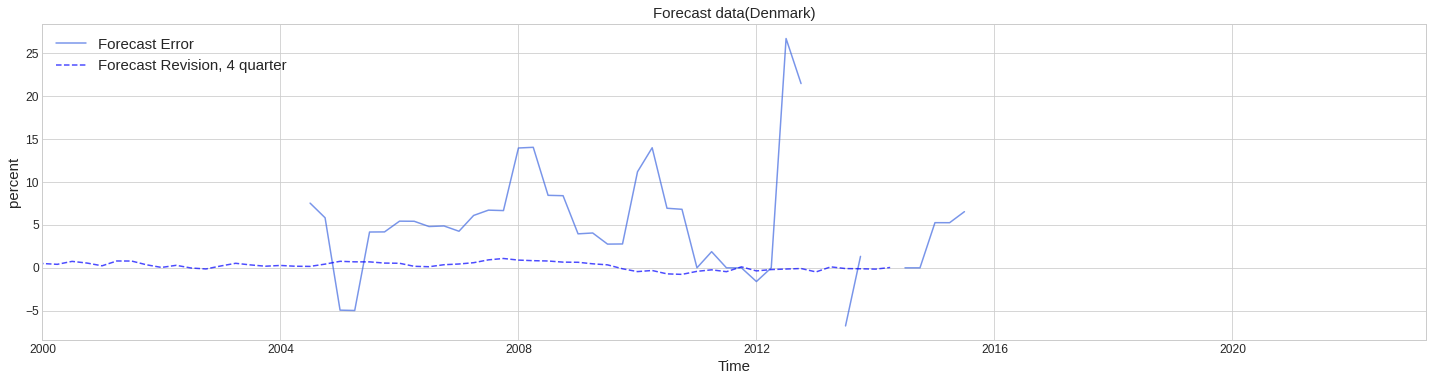

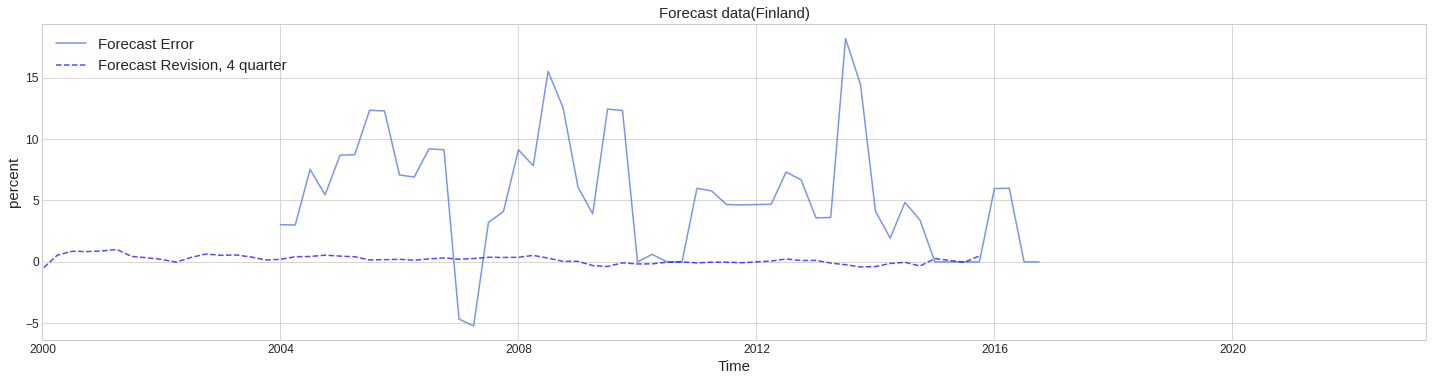

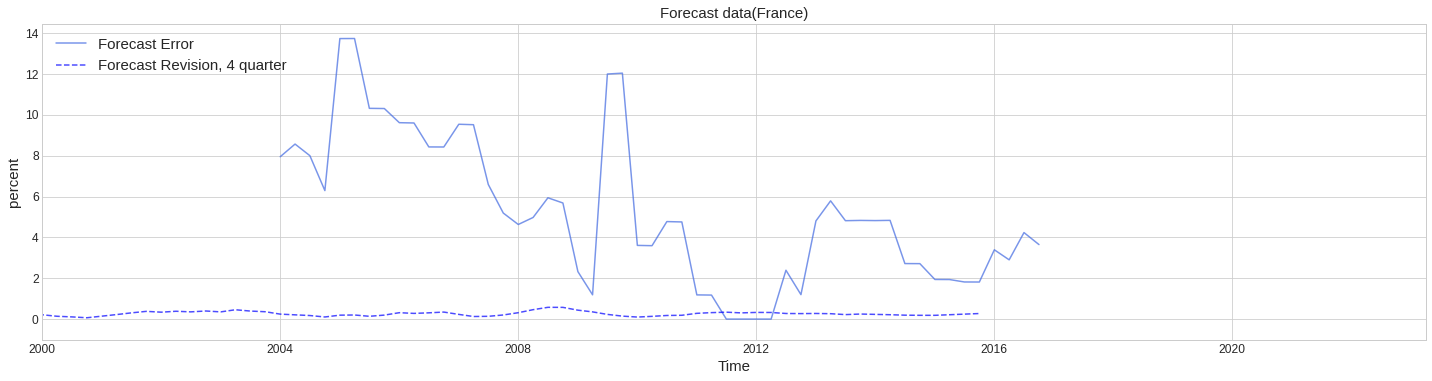

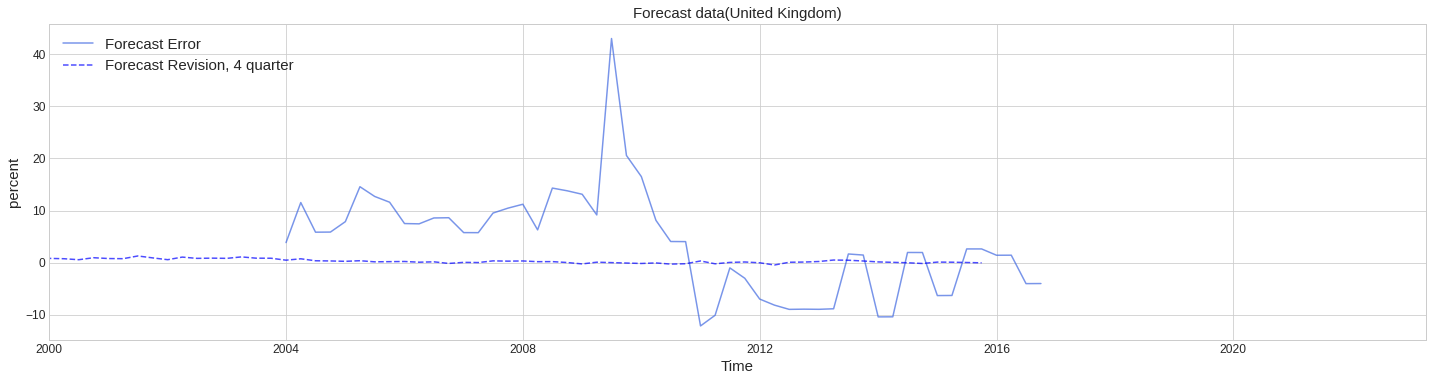

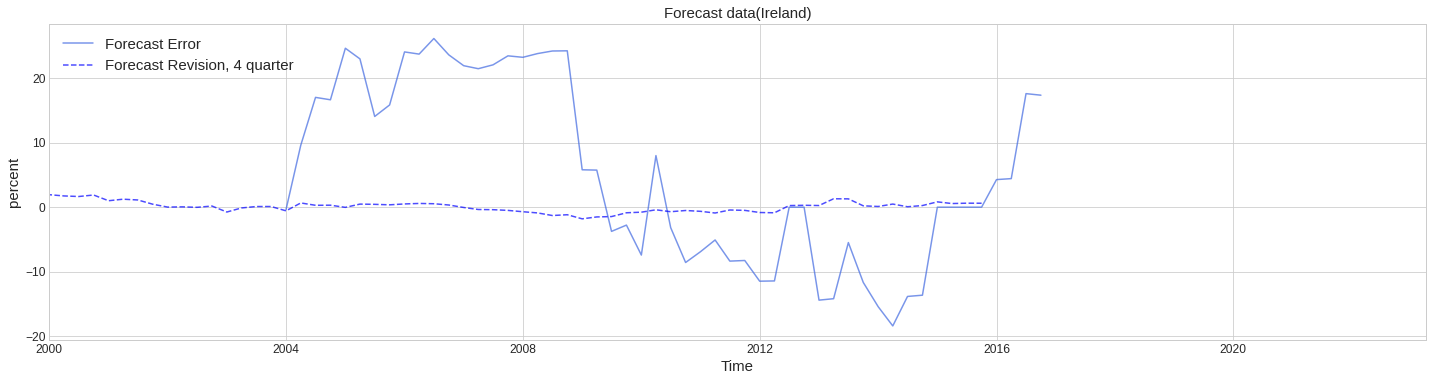

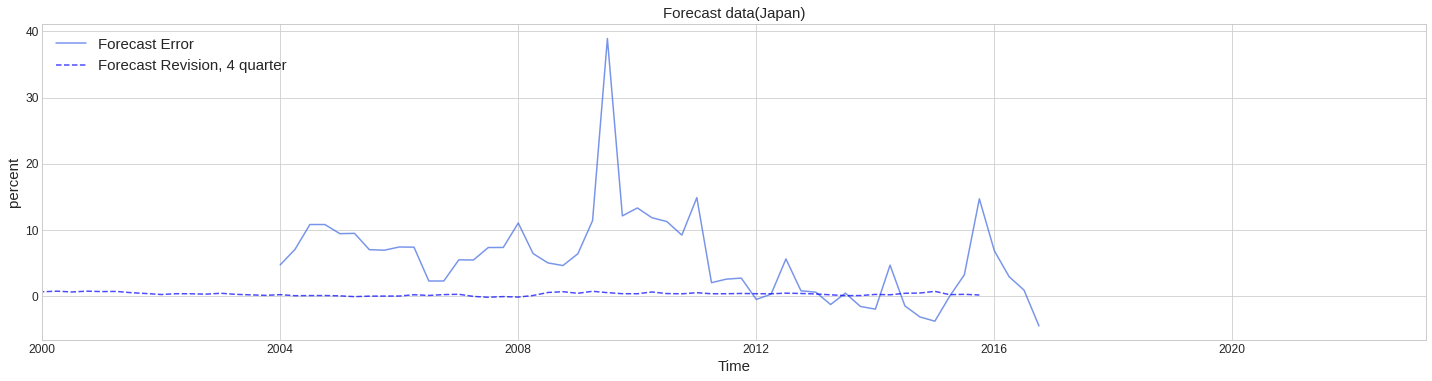

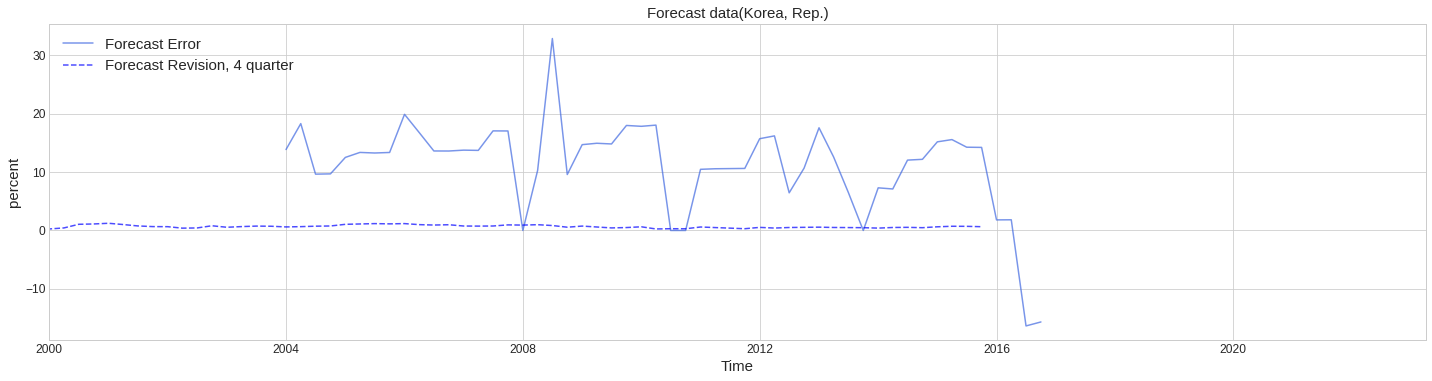

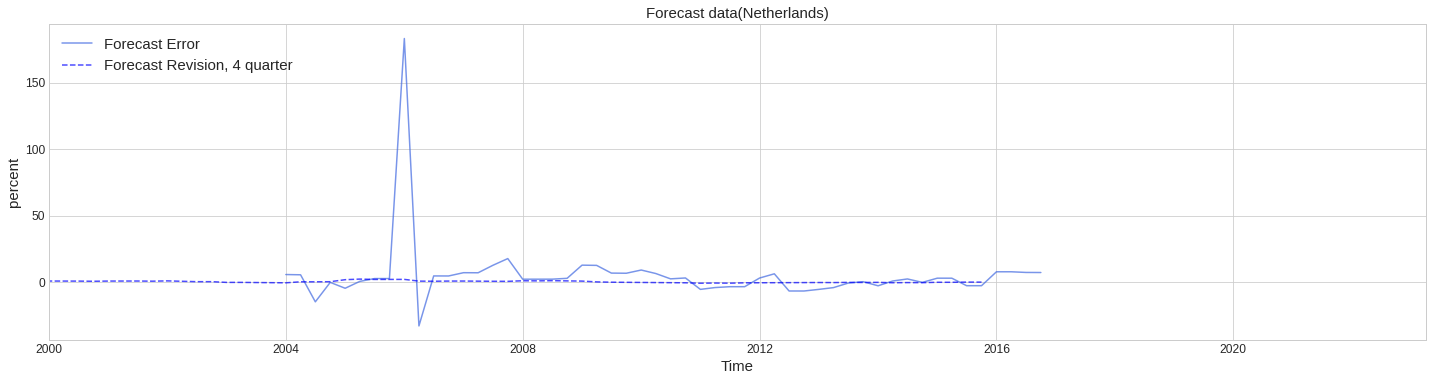

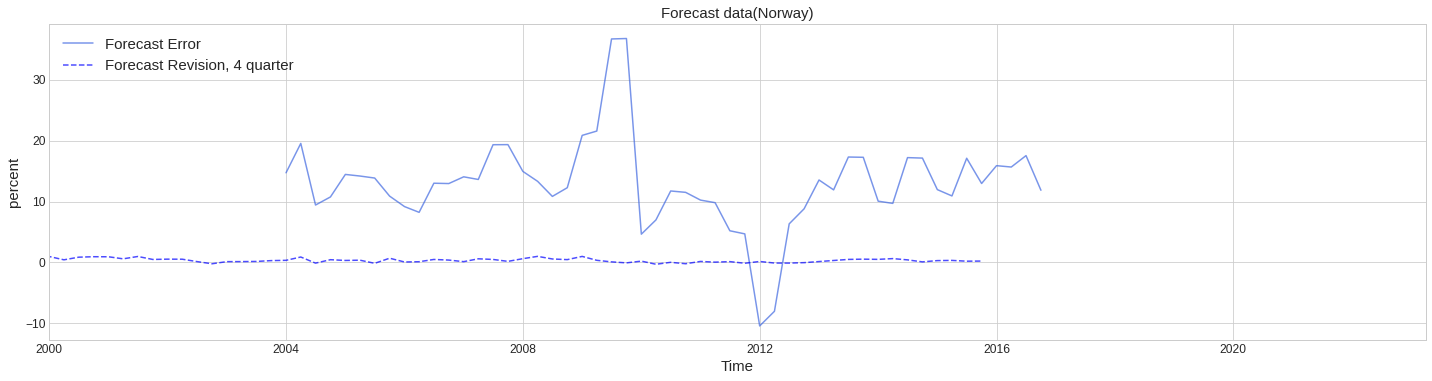

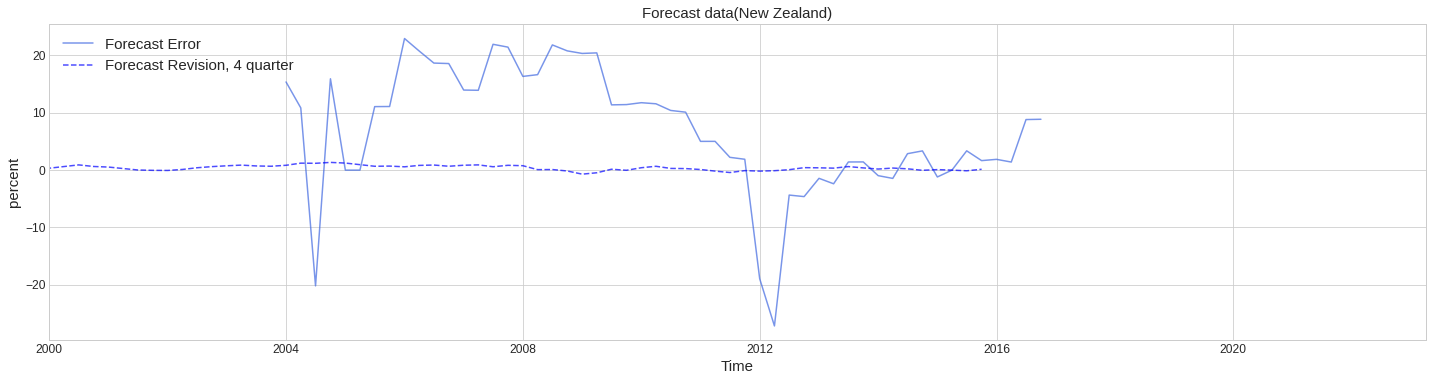

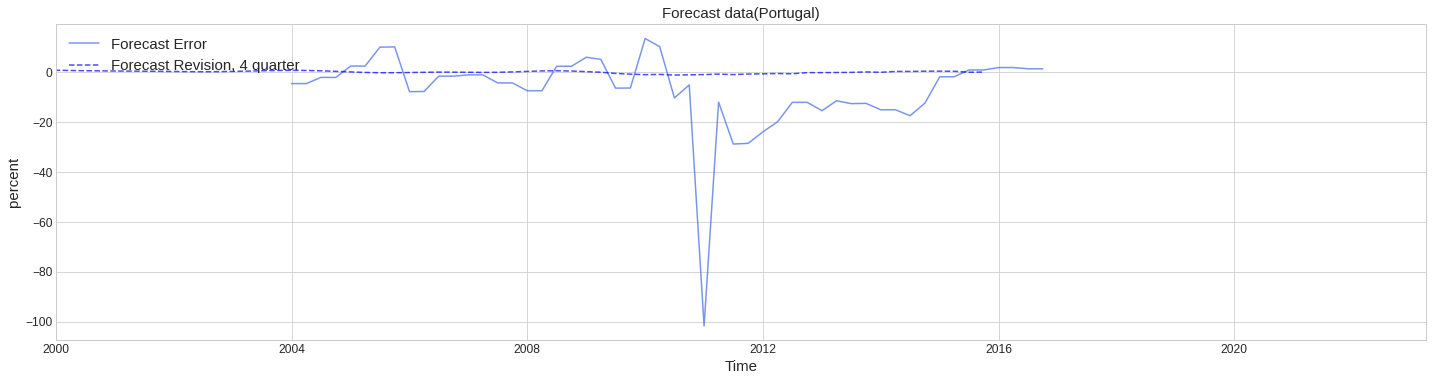

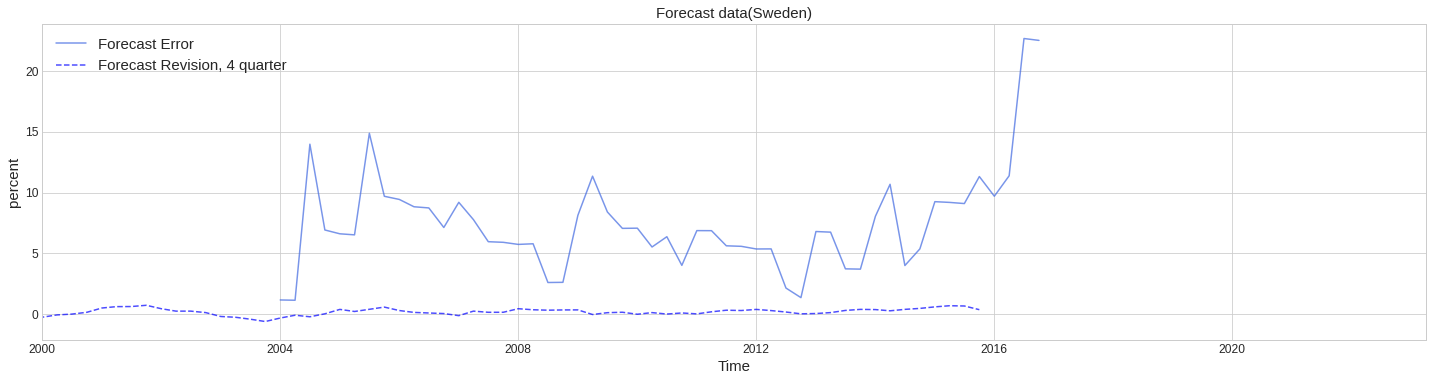

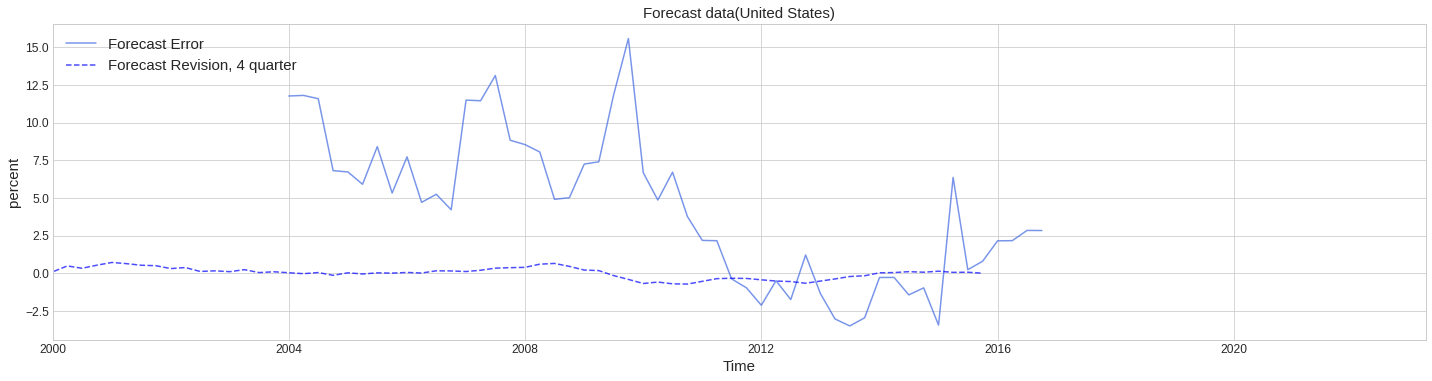

In [ ]:
for i in range(0, data['isocode'].unique().shape[0]):
  
    globals()['cond_isocode_{}'.format(i+1)] = (data['isocode'] == data['isocode'].unique()[i])
    globals()['df_isocode_{}'.format(i+1)] = data.loc[globals()['cond_isocode_{}'.format(i+1)]]
    globals()['df_isocode_count_T_{}'.format(i+1)] = globals()['df_isocode_{}'.format(i+1)].groupby(globals()['df_isocode_{}'.format(i+1)]['quarter']).count()

    globals()['cond_inv_{}'.format(i+1)] = (globals()['df_isocode_count_T_{}'.format(i+1)]['FE'] == 0)
    globals()['df_isocode_count_T_{}'.format(i+1)] = globals()['df_isocode_count_T_{}'.format(i+1)].loc[~globals()['cond_inv_{}'.format(i+1)]]
    globals()['df_isocode_count_T_{}'.format(i+1)] = globals()['df_isocode_count_T_{}'.format(i+1)].reset_index()
    
    if globals()['df_isocode_count_T_{}'.format(i+1)]['quarter'].unique().shape[0] == 0:

       continue

    else:
       print('country', data['country'].unique()[i])
       print('isocode', data['isocode'].unique()[i])
       print('end:', globals()['df_isocode_count_T_{}'.format(i+1)]['quarter'].unique().max())
       print('obs.:', globals()['df_isocode_count_T_{}'.format(i+1)]['FE'].count())
       print('des. stat.', globals()['df_isocode_{}'.format(i+1)]['FE'].describe())

       plt.figure(figsize=(20, 250)).set_facecolor('white')
       plt.style.use('seaborn-whitegrid')

       plt.subplot(data['isocode'].unique().shape[0], 1, i+1)
       plt.title('Forecast data({})'.format(data['country'].unique()[i]), fontsize=15)
       plt.plot(globals()['df_isocode_{}'.format(i+1)]['quarter'], globals()['df_isocode_{}'.format(i+1)]['FE'], label="Forecast Error", color='royalblue', alpha=0.7)
       plt.plot(globals()['df_isocode_{}'.format(i+1)]['quarter'], globals()['df_isocode_{}'.format(i+1)]['FR'], label="Forecast Revision, 4 quarter", color='blue', linestyle = 'dashed',  alpha=0.7)

       plt.xlabel('Time', fontsize=15)
       plt.ylabel('percent', fontsize=15)
       plt.xlim([dt.date(2000, 1, 1), dt.date(2023, 4, 1)])
       plt.ylim()
       plt.xticks(fontsize=12)
       plt.yticks(fontsize=12)
       plt.legend(loc='upper left', ncol=1, fontsize=15)

       plt.tight_layout()
       print('')